# Papers de ML

Dado que el ML/DL es un tema relativamente nuevo surgen a diario varios papers y articulos explicando temas relacionados a esto.

Es por esto que no esta demás conocer su arquitectura:
<center><img src="img/arquitectura_paper.png"></center>

El contamplado en el curso es el siguiente: https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

Una buena herramienta para tener en cuenta al desarrollarnos como ingeniros de ML es:
1. Descargar un paper
2. Implementarlo
3. Repetir esto hasta tenerlo dominado

Siempre es util utilizar la mayor cantidad de recursos a manos disponibles sin perder el foco, es más que obvio que una institución educativa puede ofrecernos un orden y es muy facil no tenerno e irse de tema al ser autodidacta, sobre esto ultimo no tengo nada que decir, aún no se ordenarme. 

Esta parte del curso fue la más dificil hasta ahora, la metodologia de trabajo fue la siguiente:
- Ver sección completa sin coder
- Ver sección completa codeando
- Queda pendiente re-analizar nuevamente la estructura de la arquitectura y sus fundamentos.

Extra: https://comma.ai/

# Vision transformer arquitecture

La arquitecuta es la siguiente:

<center><img src="img/vision transformer arq.png"></center>

(Chat GPT): En vez de usar convoluciones (como en una CNN tradicional), ViT divide la imagen en parches, los trata como si fueran “palabras” y los procesa con un transformer puro.
El self-attention se encarga de aprender relaciones globales entre las distintas partes de la imagen.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Imagenes a utilizar:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
# image_path

# Rutas de entrenamiento y prueba
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [3]:
from torchvision import transforms
from going_modular.going_modular import data_setup

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
    ])

print(manual_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [4]:
BATCH_SIZE = 32

train_data_loader, test_data_loader, classes_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

# len(train_data_loader), len(test_data_loader), classes_names

In [5]:
image_batch, label_batch = next(iter(train_data_loader))

image, label = image_batch[1], label_batch[1]

image.shape, label

c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

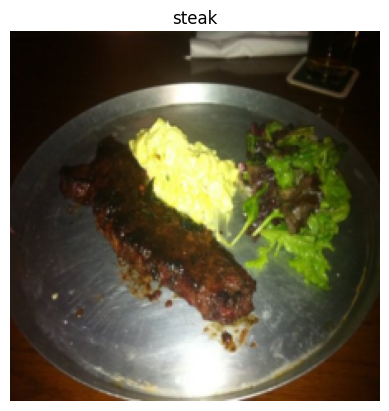

In [6]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(classes_names[label])
plt.axis("off")

# Vista de alto nivel de una arquitectura ViT

Dado que el paper es algo dificil de entender a este nivel podemos descomponer la estructura en las siguientes partes:
- **Inputs**: ¿Qué entradas tiene el modelo? 
- **Outputs**: ¿Qué salidas tiene el modelo?
- **Layers**: Capas
- **Bloques**: Colección de capas o layers
- **Modelo**: Colección de bloques

<center><img src="img/vista_alto_nivel.png"></center>

Siguiendo el paper podemos destacar lo siguiente:
<center><img src="img/arquitectura_vit_explicada.png"></center>

El fundamento matemático es bastante complejo, vamos por partes:

**1. Patch + Positional Embedding**

$$
\displaystyle
\mathbf{z}_0 = \big[ \mathbf{x}_{\text{class}} ; \mathbf{x}^1_E ; \mathbf{x}^2_E ; \dots ; \mathbf{x}^N_E \big] + \mathbf{E}_{\text{pos}}
$$
**Descripción:**  
Se divide la imagen en parches, cada parche se proyecta a un vector de dimensión $D$ mediante $\mathbf{E}$.  
Se agrega el token especial $\mathbf{x}_{\text{class}}$ y se suman los embeddings posicionales $\mathbf{E}_{\text{pos}}$ para que el modelo conozca la posición de cada parche.

---

**2. Multi-Head Self-Attention (MSA) con conexión residual**

$$
\displaystyle
\mathbf{z}'_\ell = \text{MSA}\big( \text{LN}(\mathbf{z}_{\ell-1}) \big) + \mathbf{z}_{\ell-1}, 
\quad \ell = 1, \dots, L
$$
**Descripción:**  
Cada capa de Transformer aplica normalización por capas (LayerNorm), seguido de atención multi-cabeza, y luego suma residual con la entrada original de la capa. Esto permite que cada parche "mire" a todos los demás y extraiga relaciones.

---

**3. MLP con conexión residual**

$$
\displaystyle
\mathbf{z}_\ell = \text{MLP}\big( \text{LN}(\mathbf{z}'_\ell) \big) + \mathbf{z}'_\ell, 
\quad \ell = 1, \dots, L
$$
**Descripción:**  
Después del bloque de atención, se aplica otra normalización y una red feed-forward (MLP) para procesar la información agregada. También incluye una conexión residual para estabilidad en el entrenamiento.

---

**4. Salida de clasificación**

$$
\displaystyle
\mathbf{y} = \text{LN}\big( \mathbf{z}^0_L \big)
$$
**Descripción:**  
Después de $L$ capas, se toma el token especial [CLS] procesado $\mathbf{z}^0_L$, se normaliza y se usa como representación final de la imagen. Este vector se pasa luego a una capa lineal para obtener las predicciones de clase.


Esto fue realizado con chat GPT, llevo bastante rato intentando entender la arquitectura bien pero prefiero de momento programar y luego volver sobre lo ya realizado.

# Entonces...
Siendo más tarde y habiendo avanzado en los vídeos del curso, no en codear, el porque de estas cuentas es porque el curso busca realizar esta arquitectura de manera en gran parte manual, es decir: con la menor cantidad de librerias posibles.

In [7]:
# 12/08/2025 -> Casi toda esta parte del código fue copiada sin interpretación alguna, me perdí totalmente... revisar más adelante

height = 224
width  = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size **2)

print(f"Number of patches (N) con imagen de altura (H={height}), anchura (W={width}) y patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) con imagen de altura (H=224), anchura (W=224) y patch size (P=16): 196


In [8]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


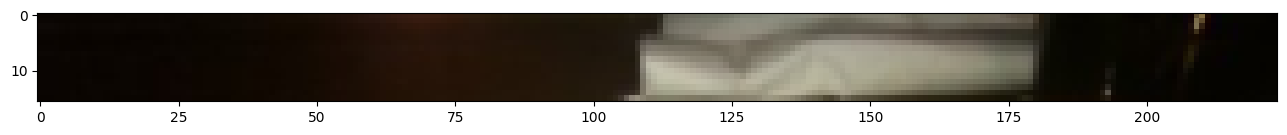

In [9]:
# Acorde al vit paper nuestra imagen debe ser cambiada a un tamaño que nos permita seperar esta en partes "horizontalmente"

image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Numero de lotes: 14.0, tamaño de los lotes: 16 x 16


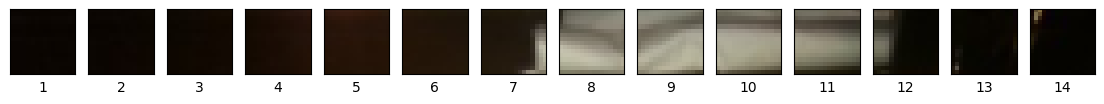

In [10]:
# Separemos la imagen en lotes...

# Características de los lotes
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "El resto debe ser 0, el tamaño de la imagen debe ser divisible por el tamaño del lote que queramos usar"
print(f"Numero de lotes: {num_patches}, tamaño de los lotes: {patch_size} x {patch_size}")

# Gráficamos...
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Para poder separar en lotes toda la imagen esta debe ser tratada como una matriz, ahí podrémos "fila por fila" separar la imagen en lotes y adaptar nuestra imagen a nuestra arquitectura vit.

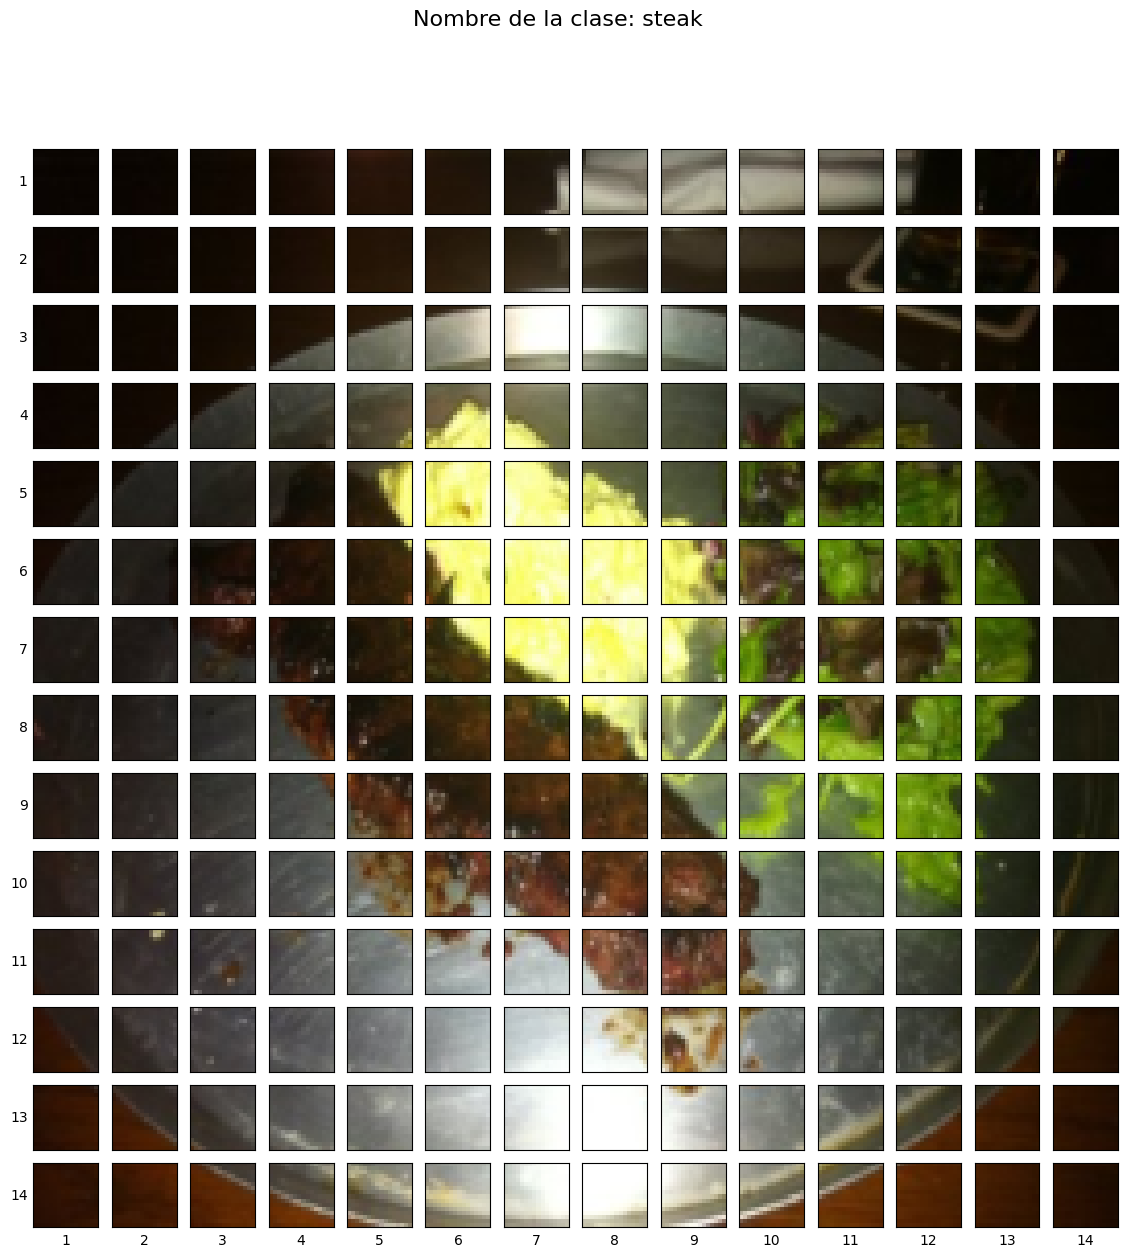

In [11]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"Nombre de la clase: {classes_names[label]}", fontsize=16)
plt.show()

# ¿Por qué usar `nn.Conv2d` para crear patches en ViT? (Chat GPT)

En Vision Transformer (ViT) los pasos previos son:

1. **Partir la imagen en parches** (p. ej., `16×16` píxeles).
2. **Convertir cada parche en un vector (embedding)** de dimensión fija (p. ej., `768` en ViT-Base).

`nn.Conv2d` puede realizar ambos pasos de una sola vez si configuramos:

- `kernel_size = patch_size` (el kernel ve exactamente un parche completo).
- `stride = patch_size` (se avanza de parche en parche, sin solape).
- `out_channels = embedding_dim` (cada parche se proyecta a ese tamaño).

---

### Ventajas

- **Eficiencia**: evita cortar y aplanar manualmente; usa kernels altamente optimizados.
- **Parámetros aprendibles**: la proyección lineal por parche se aprende como parte de la convolución.
- **Equivalencia práctica**: corresponde a la “proyección lineal” de patches que describe el paper de ViT.

---

### Configuración típica

```python
from torch import nn

patch_size = 16           # tamaño del parche (alto=ancho)
embedding_dim = 768       # ViT-Base (Tabla 1)

conv2d = nn.Conv2d(
    in_channels=3,        # RGB
    out_channels=embedding_dim,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

# Entrada:  (N, 3, 224, 224)
# Salida:   (N, 768, 14, 14)  → 14×14 = 196 parches
# Luego se reordena a (N, 196, 768) para alimentar al Transformer


In [12]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

# Usemos ahora la capa creada y pasemos la imagen en cuestión

print(f"Imagen original: {image.shape}")
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

Imagen original: torch.Size([3, 224, 224])


torch.Size([1, 768, 14, 14])

Cada uno de los 768 canales es un mapa de activación que muestra cómo responde un filtro específico a diferentes regiones de la imagen.  
Al graficar algunos de estos mapas, podemos observar qué patrones locales detecta cada filtro. (Chat GPT)

Mostrando filtros random: [159, 243, 103, 137, 562]


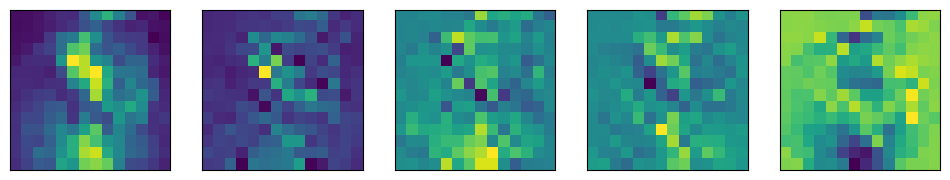

In [13]:
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Mostrando filtros random: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], xticks=[], yticks=[])

Llevamos nuestros datos a un vector con `n.Flatten`.

In [14]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [15]:
# Capa Flatten
flatten = nn.Flatten(start_dim=2,
                     end_dim=3) 

image_out_of_conv_flattened = flatten(image_out_of_conv)

In [16]:
print(f"Tamaño original: {image.shape}")
print(f"Tamaño luego de Conv2d: {image_out_of_conv.shape}")
print(f"Tamaño luego de Conv2d y flatten: {image_out_of_conv_flattened.shape}")

Tamaño original: torch.Size([3, 224, 224])
Tamaño luego de Conv2d: torch.Size([1, 768, 14, 14])
Tamaño luego de Conv2d y flatten: torch.Size([1, 768, 196])


Tal como podemos ver, fuimos adaptando nuestra imagen a gusto según los requerimientos de la arquitectura vit...

Casi todo lo realizado hasta el momento me llevo días, estoy copiando código tratando de entenderlo...

In [17]:
# Dimensión correcta siguiendo la formula:

image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


Ahora bien, llevmos los filtros a la forma pedida por la arquitectura...

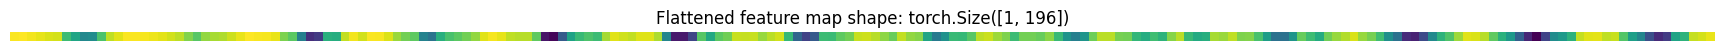

In [18]:
# COPIADO Y PEGADO, LO LEI Y VI EL VÍDEO UNAS 3 VECES

single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [19]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 4.2790e-04,  1.2192e-03, -8.2136e-03, -2.1147e-02, -3.6890e-02,
          -4.1004e-02, -2.1474e-01, -2.8369e-01, -3.6806e-01, -3.5401e-01,
          -1.9253e-01, -6.3107e-02, -2.6669e-02, -1.0428e-03,  7.8228e-04,
          -6.4207e-03, -1.2746e-02, -2.5534e-02, -4.4994e-02, -6.4725e-02,
          -1.2812e-01, -1.7689e-01, -1.0983e-01, -8.6113e-02, -7.9935e-02,
          -4.9547e-02, -2.0469e-02,  3.7037e-03, -2.5901e-03, -6.2444e-03,
          -1.8487e-02, -1.3407e-01, -1.7097e-01, -3.8890e-01, -5.9913e-01,
          -5.7194e-01, -2.4966e-01, -2.5820e-01, -6.0866e-02, -8.0418e-03,
          -4.2992e-02,  6.1880e-04, -2.0540e-03, -3.2659e-02, -1.0121e-01,
          -1.4435e-01, -1.6869e-01, -3.8430e-01, -4.2454e-01, -2.5292e-01,
          -1.9692e-01, -1.7037e-01, -1.4323e-01, -1.0844e-01, -2.8144e-02,
          -4.5447e-03, -2.2111e-02, -6.3755e-02, -7.2171e-02, -7.0599e-02,
          -1.6522e-01, -6.5400e-01, -6.7992e-01, -4.9372e-01, -2.9079e-01,
          -2.2048e-01, -1

# ¿Qué hicimos hasta ahora?

Llevamos una imagen 2D a un vector 1D legible para nuestra arquitectura...

Todo esto puede ser llevado a una clase, que luego funcione como modulo... sacando los gráficos que nos aportan una compresión de lo realizado como principiantes.

Realizaremos entonces...:

1. Crearemos la clase `PatchEmbedding`, subclase de nn.Module.
2. Tendrá como parametros `in_channels=3, patch_size=16 y embedding_dim=768`. 
3. Crearémos la capa para transformar la imagen en batches `nn.Conv2d()`.
4. Creamos la capa `nn.Flatten()` para llevarlo a una dimensión.
5. Sobreescribiremos `forward()`.
6. Nos aseguraremos que el tamaño del output sea el referquerido por la arquitectura ViT: *N x P^2 x C*.

In [20]:
# 1. Creamos la clase...
class PatchEmbedding(nn.Module):
    """Llevaremos un input 2D a uno 1D
    
    Args:
        in_channels(int): Numero de colores para la imagen de entrada. Default es 3.
        patch_size(int): Tamaño de los lotes. Default es 16.
        embedding_int(int): Tamaño del vector a llevar a cabo la imagen. Default 768.
    """

    # 2. Constructor con sus correspondientes atributos y capas
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Creamos la capa nn.Conv2d()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size)
        
        # 4. Creamos la capa nn.Flaten

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    # 5. Sobreescribimos forward..()
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "Tamaño incorrecto, la resolución debe ser divisible por el tamaño del lote"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [21]:
# Instanciamos un objeto asociado a la clase PatchEmbedding

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Imagen original {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Imagen original torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [22]:
# Tamaño de lote y dimensión
batch_size = patch_embedded_image.shape[0] # 166
embedding_dimension = patch_embedded_image.shape[-1] # 768

# Clase token, tensor de 1s utilizado luego como filtro
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Primeros 10 elementos, serán en total 768 1s.
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [23]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

# patch_embedded_image_with_class_embedding

Yendo a las formulas el número de lotes sigue la siguiente cuenta: *N = HW / P^2*

In [24]:
number_of_patches = int((height * width) / patch_size**2) # N

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

# Sobre el código realizado previamente

Hemos adaptado una imagen a un tensor de salida asociado con las cuentas correspondientes a nuestro modelo, ¿qué sigue? 

Hacer todo esto en una sola celda, ¿es posible? Sí, de hecho rara vez es necesario tanto código: los objetivos educativos hacen que la compliquemos un poco más...

Dada la imagen explicativa mostrada en el github no tocaré el código para nada y luego adjuntaré la foto asociada en donde se explica como hicimos todo esto en una sola celda.

Realizaremos entonces:

1. Un tamaño de lote
2. Tomarémos una imagen y guardaremos su alto y ancho.
3. Añadiremos una dimensión a una imagen para que sea compatible con nuestra capa `PatchEmbedding`.
4. Crearemos una capa `PatchEmbedding`.
5. Pasaremos una imagen por `PatchEmbedding` para crear una secuencia de lotes.
6. Crearemos la clase `token`
7. Pasaremos por `token` los lotes creados en el paso 5.
8. Crearemos las cuentas asociadas (Este paso no decia exatamente esto, pero lo voy a dejar así porque es de momento lo que entendí, lo mal que esta redactado es un reflejo de mi pesima compresión de momento)
9. (SIN TRADUCIR) Adding the position embedding to the class token and patch embeddings created in step 7.

In [25]:
# 1. Tamaño de lote
patch_size = 16

# 2. Gauardar ancho y alto de imagen
height, width = image.shape[1], image.shape[2] # Recoremos que [0] no es dado que es RGB, alto, ancho

# 3. Dimensión extra para que sea compatible con PatchEmbedding
x = image.unsqueeze(0)

# 4. Capa PatchEmbedding
patch_embeddeding_layer = PatchEmbedding(in_channels=3,
                                      patch_size=patch_size,
                                      embedding_dim=768)

# 5. Pasarémos la imagen por la capa Embedding
patch_embedding = patch_embeddeding_layer(x)

# 6. Clase token

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

# 7. Pasamos los lotes por la clase token
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding

In [26]:
print(f"Dimensión de la imagan: {image.shape}")
print(f"Imagen a tensor: {x.shape}")
print(f"Dimensión luego de la capa embedding shape: {patch_embedding.shape}")
print(f"Dimensión de la clase token embedding: {class_token.shape}")
print(f"Dimensión de 'Patch embedding with class token': {patch_embedding_class_token.shape}")
print(f"Dimensión de 'Patch and position embedding': {patch_and_position_embedding.shape}")

Dimensión de la imagan: torch.Size([3, 224, 224])
Imagen a tensor: torch.Size([1, 3, 224, 224])
Dimensión luego de la capa embedding shape: torch.Size([1, 196, 768])
Dimensión de la clase token embedding: torch.Size([1, 1, 768])
Dimensión de 'Patch embedding with class token': torch.Size([1, 197, 768])
Dimensión de 'Patch and position embedding': torch.Size([1, 197, 768])


# Entonces...:
<center><img src="img/vit_ecuaciones.png"></center>

Como proximo paso debemos crear la clase `MultiheadSeldAttentionBlock` como subclase de `torch.nn.Module`, esta nos permitirá simular la segunda ecuación del paper.

Para esto realizaremos:
1. Crearemos la clase en cuestión.
2. Inicializaremos la clase con los hiperparametros de la tabla 1 del paper para la Vit-Base model.
3. Crearemos una capa `torch.nn.LayerNorm()` con el parametro `normalized_shape` con la dimensión D.
4. Crearemos un objeto `multi-head attention (MSA)` con los parametros `embed_dim, num_heads, droput y batch_first`.
5. Sobreescribiremos `forward()` pasando las entradas de la capa de normalización y MSA.

In [27]:
# 1. Creamos la clase

class MultiheadSelfAttentionBlock(nn.Module):
    """ MSA """

    # 2. Hiperparametros
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()

        # 3. Capa de Norm Layer(LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Capa MSA
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    
    # Forward()
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                              key=x,
                                              value=x,
                                              need_weights=False)
        
        return attn_output

In [28]:
# Instanciamos MSA

multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape: {patch_and_position_embedding.shape}")
print(f"Output shape: {patched_image_through_msa_block.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


# Multi Perceptron Layer

Siguiendo con la arquitectura debemos crear una capa MPL. Esto nos permitirá replicar la ecuación 3.

Para esto realizaremos:

1. Crearemos la clase `MLPBlock` como subclase de `torch.nn.Module`.
2. Inicializaremos  clase con los hiperparametros de la Tabla 1 y 3 de ViT paper para el ViT-Base model.
3. Cremos la capa de `torch.nn.LayerNorm()` con el parametro `normalized_shape`.
4. Creamos una serie de capas MLP usando `torch.nn.Linear(), torch.nn.Dropout() y torch.nn.GELU()` con los hiperparametros de la tabla 1 y 3.
5. Sobreescribiremos `forward()` pasando los inputs de las capas LN y MLP.

In [29]:
# 1. Creamos la clase
class MLPBlock(nn.Module):
    """ Capa multicapa normalizada con bloques de perceptrones """
    # 2. Inicializamos clase con los hiperparametros de la tabla 1 y 3.
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
    
        # 3. Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Creamos las capas multiperceptron (MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    # Sobreescribimos forward()
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [30]:
# Instanciamos MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape: {patched_image_through_msa_block.shape}")
print(f"Output shape: {patched_image_through_mlp_block.shape}")

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


# Transformer Encoder

Ahora que ya tenemos la ecuación 2 y 3 creada, es decir: el `MultiheadSelfAttentionBlock` y el `MLPBlock` podrémos crear el transformer encoder.

Para esto realizaremos lo siguiente:

1. Crearemos la clase `TransformerEncoderBlock` como subclase de `torch.nn.Module`.
2. Inicializaremos esta con los hiperparametros de la tabla 1 y 3 del ViT paper para el modelo ViT-Base model.
3. Intanciaremos un bloque `MSA` para la ecuación 2 usando `MultiheadSelfAttentionBlock`.
4. Instanciaremos un bloque `MLP` para la ecuación 3 usando `MLPBlock`.
5. Sobreescribiremos `forward()`.
6. Crearemos una conexión para los bloques `MSA`.
7. Crearemos una conexión para los bloques `MLP`


In [44]:
# 1. Creamos la clase
class TransformerEncoderBlock(nn.Module):
    """ Creamos un Transformer Encoder block """
    # 2. Inicializaremos los hiperparametros
    def __init__(self,
                 embedding_dim:int=768, # D
                 num_heads:int=12, # Heads tabla 1
                 mlp_size:int=3072, # MLP tabla 1
                 mlp_dropout:float=0.1, # Dropout tabla 3
                 attn_dropout:float=0): # Dropout capas de atención
        super().__init__()

        # 3. Crear un bloque MSA (ecuación 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Crear un bloque MLP (ecuación 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
    
    # 5. Sobreescribimos forward()
    def forward(self, x):
        # 6 y 7
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [45]:
# Instancia de TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()
transformer_encoder_block

TransformerEncoderBlock(
  (msa_block): MultiheadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

# torch.nn.TransformerEncoderLayer

Podrémos sin embargo realizar esto valiendonos de estructuras ya proporcionadas por pyTorch...
https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

In [46]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# Unamos todo y creemos ahora si la arquitectura ViT.

La ecuación 4 la pondrémos en la misma clase.

Para esto realizaremos:
1. Crearemos la clase llamada `ViT` como subclase de `torch.nn.Module`.
2. Inicializaremos la misma con los hiperparametros de la tabla 1 y 3 del ViT Paper para el modelo ViT-Base.
3. Asegurarnos de que el tamaño de la imagen sea divisible por el tamaño del lote.
4. Calcular el número de lotes usando la formula *N = HW / P^2* donde *H* es la altura(heith) de la imagen, *W* es la anchura(width) de la imagen y *P* el tamaño del lote.
5. Crear una clase `clases_embedding` correspondiente a la ecuación 1. (token)
6. Crear un vector `position_embedding` correspondiente a la ecuación 1. 
7. Crear una capa `embedding_dropout` como la explicada en el **Appendix B.1** del ViT Paper.
8. Crear la capa `patch_embedding`.
9. Crear una serie de TransformerEncoders pasando una lista de `TransformerEncoderBlocks` (ecuación 2 y 3).
10. Crear una MLP head usando `torch.nn.LayerNorm()`, `torch.nn.Sequential()`, `torch.nn.Linear()` y al final una capa `torch.nn.Sequential()`.
11. Sobreescribir `forward()`.
12. Obtener un batch_size del input (primer elemento de la dimensión [0]).
13. Creamos un `patching embedding` usando la capa creada en el paso 8.
14. Creamos un `patch_embedding` usando la capa creada en el paso 5.
15. Concatenar las clases creadas en los pasos 13 y 12 usando `torch.cat()` (ecuación 1).
16. Añadiremos el vector `position_embedding` creado en el paso 6 a la `clase_token` creada en el paso 14.
17. Pasamos el lote y el position_embedding por la capa creada en el paso 7.
18. Pasamos el resultado del paso 17 por la pila de capas Transformer Encoder creada en el paso 9 (Ecuaciones 2 y 3).
19. Tomamos la salida en el índice 0 de la pila de encoders (paso 18) y la pasamos por la MLP head (paso 10) (Ecuación 4).
20. Instanciamos un ViT Transformer

In [47]:
# 1. Creamos la clase ViT como subclase de nn.Module

class ViT(nn.Module):
    """ Crearemos una arquitecuta Vision Transformer con los hiperparametros default del modelo ViT-Base"""

    # 2. Constructor con los hiperparametros de la tabla 1 y 3.
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transform_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        # 3. Asegurarnos de que el tamaño sea valido
        assert img_size % patch_size == 0, "Tamaño de lote o imagen invalido, revisar"

        # 4. Numero de lotes
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Crear clase embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Crear position_embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches +1, embedding_dim),
                                               requires_grad=True)
        
        # 7. Capa embedding_droput
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Capa patch_embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Transformer Encoder Block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout)])
        
        # 10. Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Sobreescribiremos forward()
    def forward(self, x):

        # 12. Tamaño del lote
        batch_size = x.shape[0]

        # 13. Clase token
        class_token = self.class_embedding.expand(batch_size, -1, -1) # La ultima

        # 14. Crearemos patch_embedding -> ecuación 1
        x = self.patch_embedding(x)

        # 15. Concatenamos las clases
        x = torch.cat((class_token, x), dim=1)

        # 16. Añadimos el vector posición
        x = self.position_embedding + x

        # 17. Pasamos a la capa embedding_dropout
        x = self.embedding_dropout(x)

        # 18. Seguimos con transformer_encoder
        x = self.transformer_encoder(x)

        # 19. Tomamos todo el clasificador
        x = self.classifier(x[:,0])
        return x

In [49]:
# 20. Ahora sí, creamos una instancia de ViT

batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) 

# Print out the change in shapes
print(f"Tamaño de class token embedding single: {class_token_embedding_single.shape}")
print(f"Tamaño de class token embedding expanded: {class_token_embedding_expanded.shape}")

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(classes_names))

vit(random_image_tensor)

Tamaño de class token embedding single: torch.Size([1, 1, 768])
Tamaño de class token embedding expanded: torch.Size([32, 1, 768])


tensor([[-0.5056,  0.0274, -0.6363]], grad_fn=<AddmmBackward0>)

In [53]:
from torchinfo import summary

summary(model=vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Ya tenemos el modelo en una clase...

Ahora podrémos crear un optimizador, función de perdida y entrenarlo sin más...

In [56]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit, 
                       train_dataloader=train_data_loader,
                       test_dataloader=test_data_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [00:42<06:22, 42.52s/it]

Epoch: 1 | train_loss: 2.2217 | train_acc: 0.3750 | test_loss: 2.8164 | test_acc: 0.2604


 20%|██        | 2/10 [01:23<05:31, 41.44s/it]

Epoch: 2 | train_loss: 1.4352 | train_acc: 0.2695 | test_loss: 1.8174 | test_acc: 0.2604


 30%|███       | 3/10 [02:07<04:59, 42.74s/it]

Epoch: 3 | train_loss: 1.3742 | train_acc: 0.3203 | test_loss: 1.0151 | test_acc: 0.5417


 40%|████      | 4/10 [02:48<04:12, 42.00s/it]

Epoch: 4 | train_loss: 1.2585 | train_acc: 0.2656 | test_loss: 1.2424 | test_acc: 0.1979


 50%|█████     | 5/10 [03:29<03:27, 41.56s/it]

Epoch: 5 | train_loss: 1.2005 | train_acc: 0.3398 | test_loss: 1.0052 | test_acc: 0.5417


 60%|██████    | 6/10 [04:11<02:46, 41.74s/it]

Epoch: 6 | train_loss: 1.1230 | train_acc: 0.4453 | test_loss: 1.4058 | test_acc: 0.2604


 70%|███████   | 7/10 [04:55<02:08, 42.68s/it]

Epoch: 7 | train_loss: 1.1705 | train_acc: 0.4141 | test_loss: 1.1840 | test_acc: 0.1979


 80%|████████  | 8/10 [05:37<01:24, 42.49s/it]

Epoch: 8 | train_loss: 1.1177 | train_acc: 0.4180 | test_loss: 1.3082 | test_acc: 0.2604


 90%|█████████ | 9/10 [06:19<00:42, 42.36s/it]

Epoch: 9 | train_loss: 1.2996 | train_acc: 0.2656 | test_loss: 1.0365 | test_acc: 0.5417


100%|██████████| 10/10 [07:03<00:00, 42.33s/it]

Epoch: 10 | train_loss: 1.1620 | train_acc: 0.2773 | test_loss: 1.2958 | test_acc: 0.1979


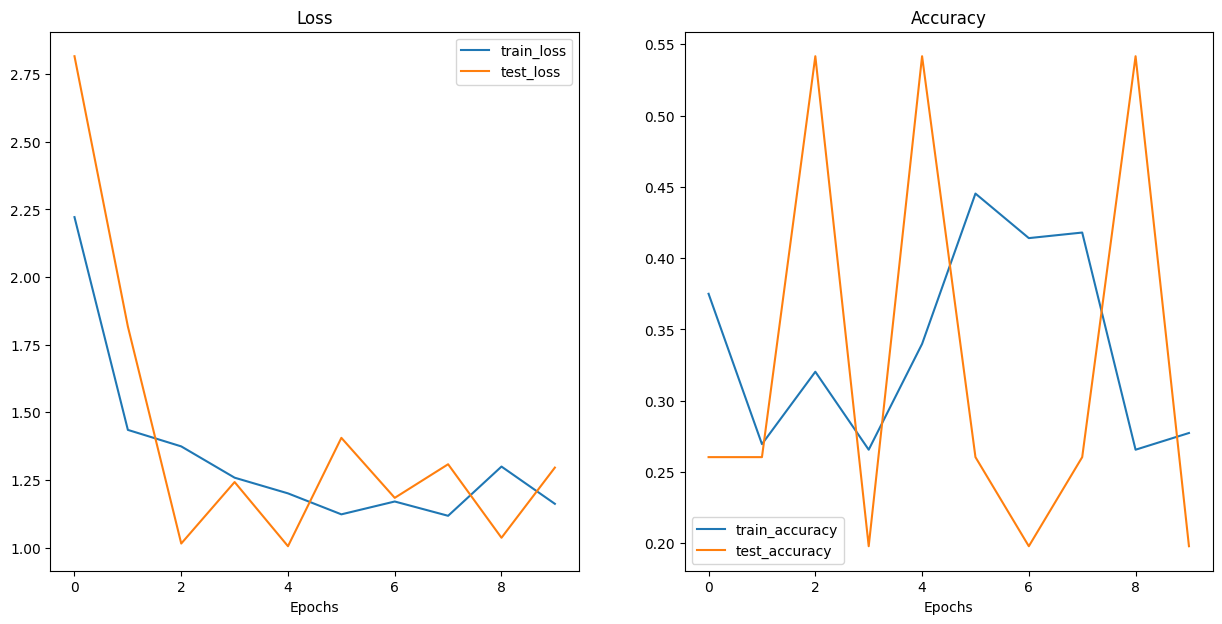

In [57]:
# Veamos que tan bien salio esto...

from helper_functions import plot_loss_curves

plot_loss_curves(results)

Claramente los resultados son cualquier cosa, o al menos no son los ideales...

Debemos entonces buscar otra manera de probar nuestra arquitectura, en teoria seguimos un buen paper, en teoria... podemos probar entonces lo aprendido en *transfer learning*,

In [65]:
# Descargamos experimento ya entrenado DEFAULT, es decir: el mejor disponible

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes_names))

summary(model=pretrained_vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [66]:
# Descarguemos nuestro set de datos

from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

# image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [67]:
# Directorios

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [68]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [72]:
train_data_loader_pretrained, test_data_loader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [73]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_data_loader_pretrained,
                                      test_dataloader=test_data_loader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:46<15:56, 106.26s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 20%|██        | 2/10 [03:29<13:55, 104.42s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 30%|███       | 3/10 [05:06<11:48, 101.23s/it]

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 40%|████      | 4/10 [06:44<09:58, 99.77s/it] 

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


 50%|█████     | 5/10 [08:23<08:17, 99.49s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [09:58<06:31, 97.92s/it]

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280


 70%|███████   | 7/10 [11:34<04:52, 97.38s/it]

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883


 80%|████████  | 8/10 [13:08<03:12, 96.38s/it]

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081


 90%|█████████ | 9/10 [14:39<01:34, 94.76s/it]

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384


100%|██████████| 10/10 [16:11<00:00, 97.13s/it]

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


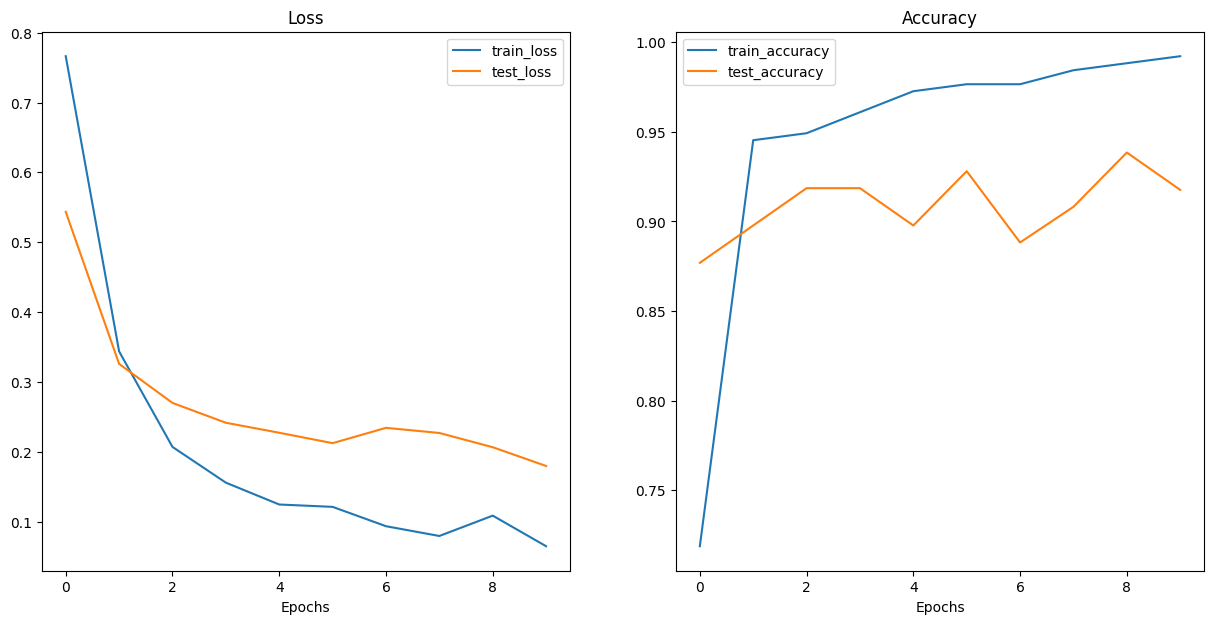

In [74]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

El modelo funciono bien, funciona, obviamente podemos jugar con el lr pero no tiene sentido ahora.

Como ultimo paso podrémos guardar este modelo y no tener que hacerlo de 0 luego, independiemente de los objetivos educativos de nuestro largo y tedioso código.

In [75]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [76]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Tamaño del modelo preentrenado {pretrained_vit_model_size}")

Tamaño del modelo preentrenado 327
